In [2]:
import numba
import numpy as np
import matplotlib.pyplot as plt
import functools

import pywt

In [3]:
import math

In [43]:
@numba.njit()
def next_index(n):
    while n & 1:
        n = n >> 1
    return n >> 1

@numba.njit()
def unscramble(j, sz):
    i = j
    while i < j:
        i = next_index(sz // 2 + i)
    return i

@numba.njit()
def larger_half(n):
    return n - n // 2

@numba.njit()
def is_even(n):
    return bool((n & 1)^1)

@numba.njit()
def interleave(a):
    n = len(a)
    m = n // 2
    l = a[:m]
    r = a[m:]

    for i in range(m):
        j = next_index(i)
        l[i], r[j] = r[j], l[i]

    m2 = m // 2
    for j in range(m2 - 1):
        k = next_index(m2 + j)
        while k < j:
            k = next_index(m2 + k)
        r[j], r[k] = r[k], r[j]

    if n - m > 1:
        b = 1 if m & 1 else 0
        interleave(r[b:])

    return a

In [44]:
@numba.njit()
def interleave_work(x):
    n = len(x)
    m = len(x) // 2
    work = x[:m << 1].copy()

    for k in range(m):
        i = 2 * k
        x[i] = work[m + k]
        x[i + 1] = work[k]

    return x

In [47]:
n = 100_000
interleave_work(np.arange(n, dtype=np.float64))

array([50000.,     0., 50001., ..., 49998., 99999., 49999.])

In [35]:
%%timeit
interleave(x)

1.35 ms ± 9.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [48]:
%%timeit
interleave_work(np.arange(n, dtype=np.float64))

105 μs ± 2.46 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [199]:
@numba.njit()
def lift_apply(x, i, offset, vals):
    v = vals[0] * x[i + offset]
    if len(vals) > 1:
        v += lift_apply(x, i, offset + 1, vals[1:])
    return v

@numba.njit()
def lift_periodic_bc(x, i, offset, vals):
    io = (i + offset) % len(x)
    v = vals[0] * x[io]
    if len(vals) > 1:
        v += lift_periodic_bc(x, i, offset + 1, vals[1:])
    return v

def step_factory(step_type, offset, vals):
    if step_type == "d":
        @numba.njit()
        def update_d(s, d):
            nd = len(d)
            max_offset = len(vals) - 1 + offset
            n_front = max(-offset, 0)
            n_back = max(max_offset, 0)
        
            for i in range(n_front):
                d[i] += lift_periodic_bc(s, i, offset, vals)
            for i in range(n_front, nd - n_back):
                d[i] += lift_apply(s, i, offset, vals)
            for i in range(nd - n_back, nd):
                d[i] += lift_periodic_bc(s, i, offset, vals)
        return update_d
    elif step_type == "s":
        @numba.njit()
        def update_s(s, d):
            nd = len(d)
            ns = len(s)
            max_offset = len(vals) - 1 + offset
            n_front = max(-offset, 0)
            n_back = max(max_offset, 0)
        
            for i in range(n_front):
                s[i] += lift_periodic_bc(d, i, offset, vals)
            for i in range(n_front, nd - n_back):
                s[i] += lift_apply(d, i, offset, vals)
            for i in range(nd - n_back, ns):
                s[i] += lift_periodic_bc(d, i, offset, vals)
        return update_s
    else :
        @numba.njit()
        def scale(s, d):
            nd = len(d)
            ns = len(s)
            for i in range(nd):
                d[i] /= offset
            for i in range(ns):
                s[i] *= offset
        return scale

def forward(x, steps):

    s = x[::2].copy()
    d = x[1::2].copy()

    for step in steps:
        step(s, d)

    return np.concat([s, d])

In [200]:
pywt.Wavelet('bior3.1')

pywt._extensions._pywt.Wavelet(name='bior3.1', filter_bank=([-0.3535533905932738, 1.0606601717798212, 1.0606601717798212, -0.3535533905932738], [-0.1767766952966369, 0.5303300858899106, -0.5303300858899106, 0.1767766952966369], [0.1767766952966369, 0.5303300858899106, 0.5303300858899106, 0.1767766952966369], [-0.3535533905932738, -1.0606601717798212, 1.0606601717798212, 0.3535533905932738]))

In [201]:
@numba.njit()
def vec_lift_apply(x, i, j, offset, vals):
    v = vals[0] * x[i + offset, j]
    if len(vals) > 1:
        v += vec_lift_apply(x, i, j, offset + 1, vals[1:])
    return v

@numba.njit()
def vec_lift_periodic_bc(x, i, j, offset, vals):
    io = (i + offset) % len(x)
    v = vals[0] * x[io, j]
    if len(vals) > 1:
        v += vec_lift_periodic_bc(x, i, j, offset + 1, vals[1:])
    return v

In [202]:
def vec_step_factory(step_type, offset, vals):
    if vals is not None:
        max_offset = len(vals) - 1 + offset
        n_front = max(-offset, 0)
        n_back = max(max_offset, 0)
    
    if step_type == "d":
        @numba.njit()
        def update_d(s, d):
            nd = d.shape[0]
            m = d.shape[1]

            for i in range(n_front):
                for j in range(m):
                    d[i, j] += vec_lift_periodic_bc(s, i, j, offset, vals)
            for i in range(n_front, nd - n_back):
                for j in range(m):
                    d[i, j] += vec_lift_apply(s, i, j, offset, vals)
            for i in range(nd - n_back, nd):
                for j in range(m):
                    d[i, j] += vec_lift_periodic_bc(s, i, j, offset, vals)
        return update_d

    elif step_type == "s":
        @numba.njit()
        def update_s(s, d):
            nd = len(d)
            ns = len(s)
            m = d.shape[1]
        
            for i in range(n_front):
                for j in range(m):
                    s[i, j] += vec_lift_periodic_bc(d, i, j, offset, vals)
            for i in range(n_front, nd - n_back):
                for j in range(m):
                    s[i, j] += vec_lift_apply(d, i, j, offset, vals)
            for i in range(nd - n_back, ns):
                for j in range(m):
                    s[i, j] += vec_lift_periodic_bc(d, i, j, offset, vals)
        return update_s
    else :
        @numba.njit()
        def scale(s, d):
            nd = len(d)
            ns = len(s)
            m = d.shape[1]
            for i in range(nd):
                for j in range(m):
                    d[i, j] /= offset
            for i in range(ns):
                for j in range(m):
                    s[i, j] *= offset
        return scale

In [203]:
vals = np.array([1.0, 1.2, 1.3])

BiorSpline3_1 = [
    ("s",  -1, np.r_[-1/3]),
    ("d", 0, np.r_[-9/8, -3/8]),
    ("s",  0, np.r_[4/9]),
    ("scale", 3 * np.sqrt(2) / 2, None)
]

BiorSpline6_2 = [
    ("d",  0, np.r_[-1/6, 1/6]),
    ("s", -1, np.r_[-9/16, -9/16]),
    ("d", 0, np.r_[-4/3, -4/3]),
    ("s", -1, np.r_[5/32, 5/32]),
    ("scale", 4 * np.sqrt(2), None)
]


forward_1d_bior_3_1 = functools.partial(forward, steps=[step_factory(*param) for param in BiorSpline3_1])

forward_2d_bior_3_1 = functools.partial(forward, steps=[vec_step_factory(*param) for param in BiorSpline3_1])

In [204]:
n = 512
x = np.linspace(-10, 10, n)
y = np.linspace(-10, 10, n)

c = 1/np.sqrt((x**2 + y ** 2 + 0.1))
c2d = 1/np.sqrt(x**2 + y[:, None]**2 + 0.1)

In [462]:
def max_level(n, width):
    lvl = 0
    if width <= 1:
        return 0
    print(np.log2(n), np.log2(width - 1))
    while n >= 2 * (width - 1):
        print(lvl, n, width)
        lvl += 1
        n //= 2
    return lvl

In [463]:
np.log2(1024 // 1)

np.float64(10.0)

In [464]:
pywt.dwt_max_level(2, 2)

1

In [465]:
np.log2(4 / (4 - 1))

np.float64(0.41503749927884376)

In [478]:
n1 = 842
n2 = n1 + 1

wvlt = pywt.Wavelet('db6')
width = len(wvlt)
my_lvl = max_level(n1, width)
print()
print(pywt.dwt_max_level(n1, width), my_lvl)

print()
my_lvl = max_level(n2, width)
print()
print(pywt.dwt_max_level(n1, width), my_lvl)

9.717676423066395 3.4594316186372973
0 842 12
1 421 12
2 210 12
3 105 12
4 52 12
5 26 12

6 6

9.719388820942083 3.4594316186372973
0 843 12
1 421 12
2 210 12
3 105 12
4 52 12
5 26 12

6 6


In [470]:
n = 639

wvlt = pywt.Wavelet('db3')
width = len(wvlt)
my_lvl = max_level(n, width)
print()
print(pywt.dwt_max_level(n, width), my_lvl)

9.319672120946995 2.321928094887362
0 639 6
1 319 6
2 159 6
3 79 6
4 39 6
5 19 6

6 6


In [467]:
n = 640

wvlt = pywt.Wavelet('db3')
width = len(wvlt)
my_lvl = max_level(n, width)
print()
print(pywt.dwt_max_level(n, width), my_lvl)

9.321928094887362 2.321928094887362
0 640 6
1 320 6
2 160 6
3 80 6
4 40 6
5 20 6
6 10 6

7 7


In [288]:
e = np.zeros(32)
e[10] = 1

v1 = forward_1d_bior_3_1(e)

e = np.zeros(32)
e[11] = 1

v2 = forward_1d_bior_3_1(e)

v1, v2

(array([ 0.        ,  0.        ,  0.        ,  0.        , -0.35355339,
         1.06066017,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.1767767 , -0.53033009,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ]),
 array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.06066017, -0.35355339,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.53033009,  0.1767767 ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ]))

In [205]:
sc = forward_1d_bior_3_1(c)

In [209]:
sc2d = forward_2d_bior_3_1(c2d)
vs = []
for row in sc2d:
    vs.append(forward_1d_bior_3_1(row))
sc2d = np.stack(vs)

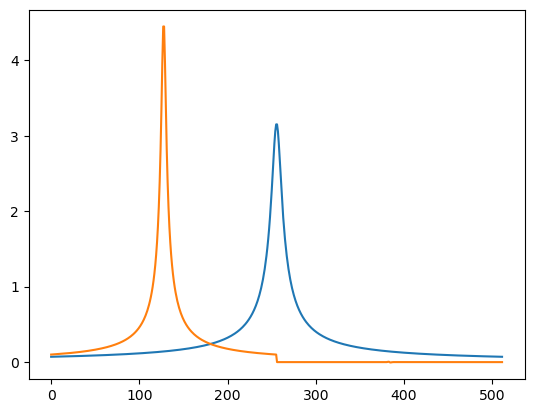

In [210]:
plt.plot(c)
plt.plot(sc)

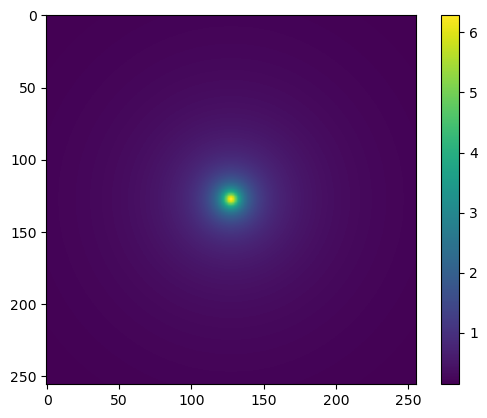

In [216]:
plt.imshow(sc2d[:n//2,:n//2])
plt.colorbar()

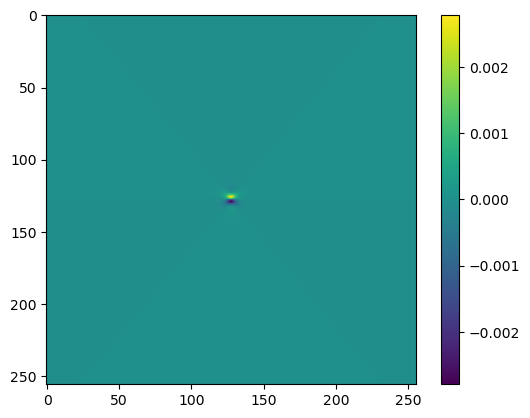

In [217]:
plt.imshow(sc2d[n//2:,:n//2])
plt.colorbar()

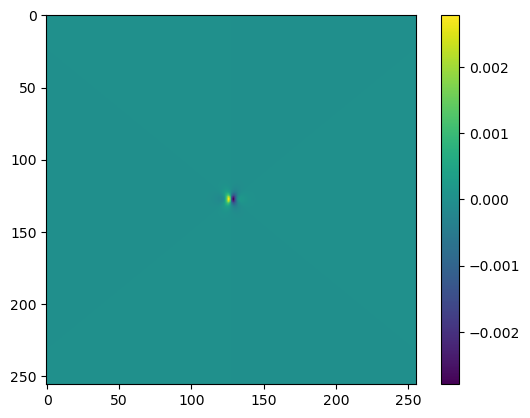

In [219]:
plt.imshow(sc2d[:n//2,n//2:])
plt.colorbar()

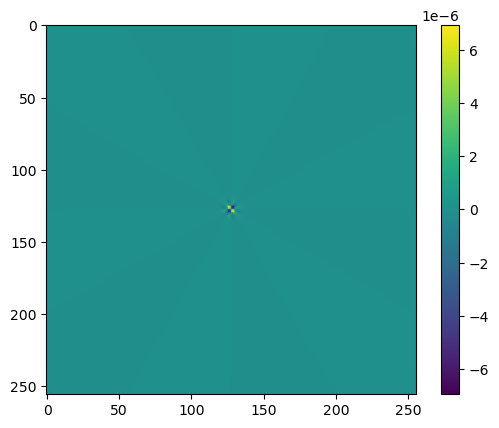

In [220]:
plt.imshow(sc2d[n//2:,n//2:])
plt.colorbar()

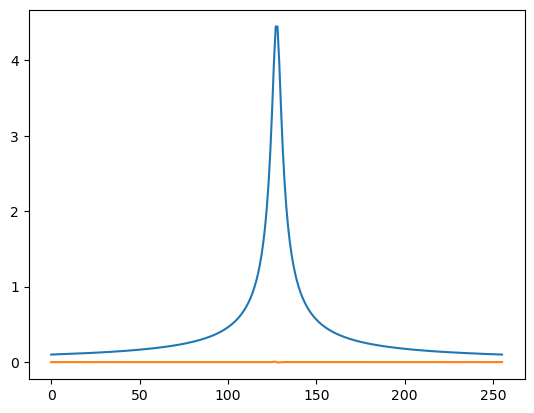

In [144]:
plt.plot(sc)
plt.plot(dc)